In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from numpy import unique
from numpy import where
from sklearn.metrics import confusion_matrix
import sklearn.cluster as cluster
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer

In [3]:
#Get Data from:
# https://drive.google.com/uc?export=download&id=1FQSjb3N2HBOd91VI4qExH-REHQYpcik-
df=pd.read_excel('CTG.xls', sheet_name='Data',header=None)

---

### Preprocessing

In [4]:
df=df.drop(0, axis=0)
#col_names=df.loc[1].values
col_names=['b', 'e', 'AC1', 'FM1', 'UC1', 'DL1', 'DS1', 'DP1', 'DR', 'nan', 'LB',
       'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV',
       'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median',
       'Variance', 'Tendency', 'nan', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE',
       'LD', 'FS', 'SUSP', 'nan', 'CLASS', 'nan', 'NSP']

df.columns=col_names
df=df.drop(1, axis=0)
df.reset_index(drop=True, inplace=True)

In [5]:
df = df.dropna(axis=1, how='all')
df = df.dropna(axis=0, how='any')

In [7]:
for i in df.columns:
    df[i] = pd.to_numeric(df[i])

In [8]:
df = df.loc[:, (df != 0).any(axis=0)] #Delete columns with only zeros
def choose_data(i):
    global df1,x, x1
    if i ==0:
        df1=df[['LB', 'AC', 'FM', 'UC','DL', 'DS', 'ASTV', 'MSTV', 'ALTV', 'MLTV' ,'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median','Variance', 'Tendency','CLASS','NSP']]
    elif i==1:
        df1=df[['b','e','LB', 'AC', 'FM', 'UC','DL', 'DS', 'ASTV', 'MSTV', 'ALTV', 'MLTV' ,'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median','Variance', 'Tendency','CLASS','NSP']]
    x=df1.loc[:, ~df1.columns.isin(['CLASS','NSP'])]
    #PCA
    pca = PCA(n_components=2)
    x1 = pca.fit(x).transform(x)

In [9]:
choose_data(1)

Find and Drop outliers

In [10]:
xdf=pd.DataFrame(x1,columns=['x11','x12'])
from scipy import stats
no_outliers_positions=xdf[(np.abs(stats.zscore(xdf)) < 3).all(axis=1)].index
outliers=list(set(xdf.index)-set(no_outliers_positions))
nxdf=xdf.to_numpy()[outliers]

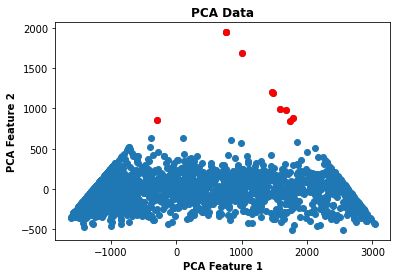

In [11]:
#Locate outliers
plt.scatter(x1[:,0], x1[:,1])
plt.scatter(nxdf[:,0],nxdf[:,1],color='red')
plt.ylabel("PCA Feature 2", fontweight='bold',c='black')
plt.xlabel("PCA Feature 1", fontweight='bold',c='black')
plt.title("PCA Data", fontweight='bold',c='black')
plt.show()

In [11]:
#Transform X
scaler = StandardScaler()
pca = PCA(n_components=2)

scaler.fit(x)
norm_x1=scaler.transform(x)
x1 = pca.fit(x).transform(x)
x2 = pca.fit(norm_x1).transform(norm_x1)

x.drop(outliers, axis=0, inplace=True)
#Normalized
scaler.fit(x)
norm_x2=scaler.transform(x)
nx1 = pca.fit(x).transform(x)
nx2 = pca.fit(norm_x2).transform(norm_x2)

#Transform Y
label = preprocessing.LabelEncoder()

fhr=df1['CLASS'].values
nsp=df1['NSP'].values
y1=label.fit(fhr).transform(fhr)
y2=label.fit(nsp).transform(nsp)

df1.drop(outliers, axis=0, inplace=True)

fhr=df1['CLASS'].values
nsp=df1['NSP'].values
ny1=label.fit(fhr).transform(fhr)
ny2=label.fit(nsp).transform(nsp)

C:\Users\manol\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\manol\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


___
**Explenation of variables:**

- **x1** --> Data
- **x2** --> Standardized Data
- **nx1** --> Data with no outliers
- **nx2** --> Standardized Data with no outliers
- **y1** --> FHR
- **y2** --> NSP
- **ny1** --> FHR with no outliers
- **ny2** --> NSP with no outliers
___

### Clustering

In [12]:
#plot heatmap of a matrix
def plot(x,truth,predictions,name):
    plt.figure(figsize=(10,6))
    sns.heatmap(x, square=False, annot=True, cbar=True, fmt='d',
    yticklabels=np.unique(predictions),
    xticklabels=np.unique(truth))

    plt.ylabel("Predicted Label", fontweight='bold',c='black')
    plt.xlabel("Truth Label", fontweight='bold',c='black')
    plt.title(name, fontweight='bold',c='black')
    

def pososta(a):
    #a8roisma pli8wn pou vriskontai sti diagwnio(True positives)
    global pososto
    true=0
    total=0
    for i in range(0,len(a)):#grammes
        for j in range(0,len(a)):#columns
            if i==j:
                true+=a[i][j]
            total+=a[i][j]
    pososto=true/total
    return pososto
    

def heatmap(truth, predictions, model, d, t, b):
    global c
    from sklearn.metrics import confusion_matrix
    df_names=["Data", "Standardized Data"]
    cm=confusion_matrix(truth, predictions)
    c=cm.T
    #Heatmap
    if model==1:
        name='Kmeans CM '+df_names[d]+" "+t+ " "+b
    elif model==2:
        name='Birtch CM '+df_names[d]+" "+t+ " "+b
    elif model==3:
        name='Agglomerative CM '+df_names[d]+" "+t+ " "+b
    plot(c,truth,predictions,name)

    plt.savefig(name, dpi=300, bbox_inches='tight')
    plt.show()

**Combinations:**
**Choose model to fill the gap (km, birtch, agglomerative)**
- ________(y1,10) -> PCA on data, clustering for FHR
- ________(ny1, 10) -> PCA on data without outliers, clustering for FHR
- ________(y2, 3) -> PCA on standardized data, clustering for NSP
- ________(ny2, 3) -> PCA on standardized data without outliers, clustering for NSP

Kmeans

In [13]:
def km(y,n):   
    p=[]#save percentage of correct labeled
    s=[]#save silhouette_score
    fm=[]#save fowlkes_mallows_score
    mi=[]#save adjusted_mutual_info_score

    import sklearn.cluster as cluster
    import matplotlib.pyplot as plt
    model1 = cluster.KMeans(n_clusters=n, init="k-means++")

    if n==10:
        b='FHR'
    elif n==3:
        b='NSP'
        
    #Choosing if data with or without outliers are used
    if len(y)==2110 or len(y)==2116:
        o=0
    elif len(y)==2126:
        o=1

    if o==0:
        dfs=[nx1, nx2]
        t="Without outliers"
        print(t)
    elif o==1:
        dfs=[x1, x2]
        t="With outliers"
        print(t)    

    df_names=["Data", "Standardized"]
        
    for d in range(0,2):
        nclusters=model1.fit_predict(dfs[d])

        #failsafe 1
        if len(unique(y))!=len(unique(model1.labels_)):
            print("ny1:10 clusters, ny2:3 clusters")
            break
        print("Diagrams for:", df_names[d])        
        
        clusters=model1.cluster_centers_
        lw = 1
        
        plt.figure()
        plt.figure(figsize=(10,8))

        def plot_clusters(targets):
            for i in range(len(targets)):
                plt.scatter(clusters[i][0], clusters[i][1], color='black', marker='*',s=200)

        if n==10:
            target_names1 = ["Cluster 0", "Cluster 1","Cluster 2", "Cluster 3","Cluster 4","Cluster 5","Cluster 6","Cluster 7", "Cluster 8","Cluster 9"]
            colors1 = ['purple', 'turquoise', 'darkorange', 'red', 'grey', 'g', 'y', 'b', 'lime', 'pink']
            for color, i, target_name in zip(colors1, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ], target_names1):
                plt.scatter(dfs[d][nclusters == i, 0], dfs[d][nclusters == i, 1], color=color, lw=lw, label=target_name)
            plot_clusters(target_names1)
        elif n==3:
            target_names2 = ["Cluster 0", "Cluster 1","Cluster 2"]
            colors2 = ['purple', 'turquoise', 'darkorange']
            for color, i, target_name in zip(colors2, [0, 1, 2], target_names2):
                plt.scatter(dfs[d][nclusters == i, 0], dfs[d][nclusters == i, 1], color=color, lw=lw, label=target_name)
            plot_clusters(target_names2)


        plt.legend(loc='best', shadow=False, scatterpoints=1)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)
        plt.title("Kmeans " + df_names[d]+" "+t+" "+b,fontweight='bold',c='black')
        plt.savefig('Kmeans '+df_names[d]+" "+t+" "+b, dpi=300, bbox_inches='tight')
        plt.show()
        
        heatmap(y, model1.labels_,1,d,t,b)
        pososta(c)
        p.append(pososta(c))

        from sklearn.metrics import silhouette_score
        s.append(silhouette_score(dfs[d], model1.labels_))

        from sklearn.metrics import fowlkes_mallows_score
        fm.append(fowlkes_mallows_score(y, model1.labels_))

        from sklearn.metrics import adjusted_mutual_info_score
        mi.append(adjusted_mutual_info_score(y, model1.labels_))

        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

    #failsafe 2
    if len(unique(y))!=len(unique(model1.labels_)):
            print("y1:10 clusters, y2:3 clusters")
            return

    a=pd.DataFrame(p)
    a.index=[df_names]
    a.columns=["Percentage of correct labeled: "]
    a['Silhouette Score']=s
    a['Fowlkes Mallows Score']=fm
    a['Adjusted Mutual Info Score']=mi
    a.to_excel('K means '+t+" "+b+'.xlsx',header=True)
    #print()
    print(a)

Without outliers
Diagrams for: Data


<Figure size 432x288 with 0 Axes>

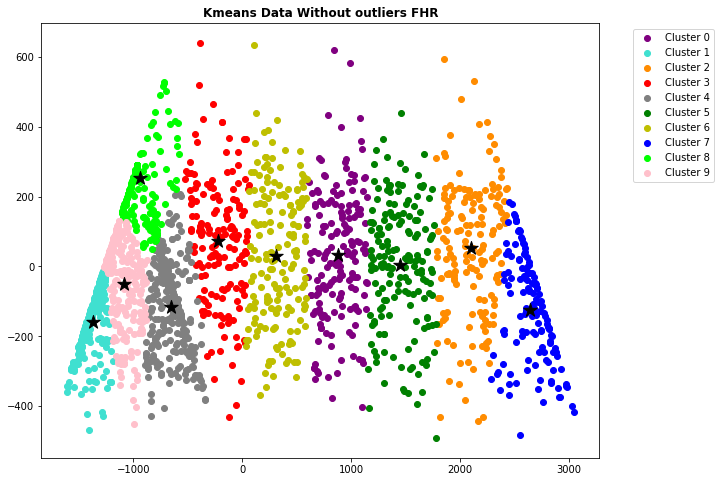

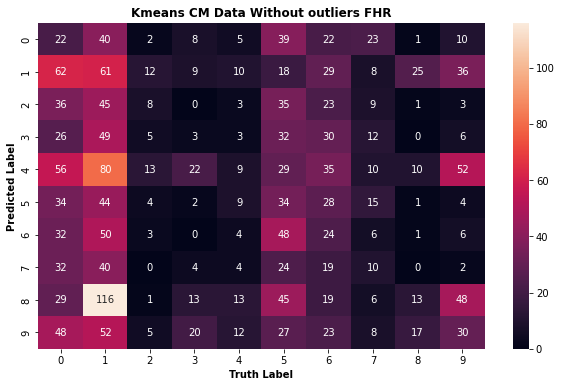

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Diagrams for: Standardized


<Figure size 432x288 with 0 Axes>

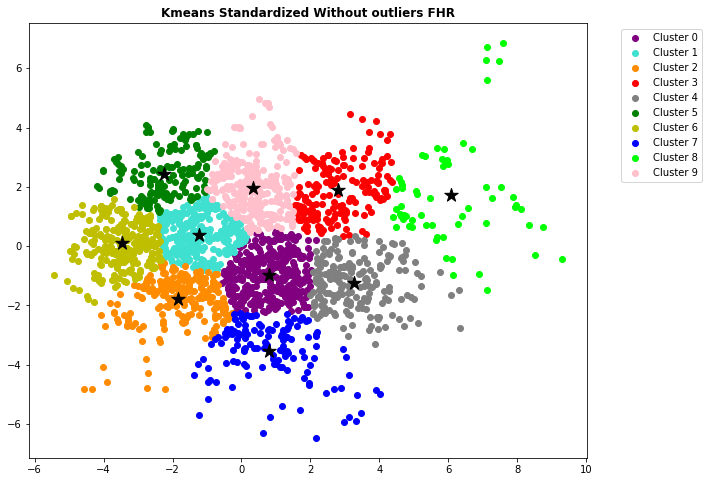

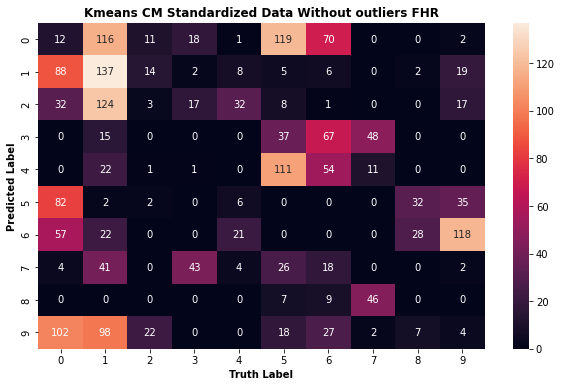

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              Percentage of correct labeled:   Silhouette Score  \
Data                                 0.101134          0.421618   
Standardized                         0.073724          0.345203   

              Fowlkes Mallows Score  Adjusted Mutual Info Score  
Data                       0.140432                    0.036019  
Standardized               0.260020                    0.298998  


In [14]:
km(ny1,10)

Birtch

In [15]:
def birtch(y,n):
	p=[]#save percentage of correct labeled
	s=[]#save silhouette_score
	fm=[]#save fowlkes_mallows_score
	mi=[]#save adjusted_mutual_info_score

	from sklearn.cluster import Birch
	if len(y)==2110 or len(y)==2116:
		o=0
	elif len(y)==2126:
		o=1

	model2 = Birch(threshold=0.01, n_clusters=n)
	df_names=["Data", "Standardized Data"]

	if n==10:
		b='FHR'
	elif n==3:
		b='NSP'
	
	if o==1:
		dfs=[x1, x2]
		t="With outliers"
		print(t)
	elif o==0:
		dfs=[nx1, nx2]
		t="Without outliers"
		print(t)

	for d in range(0,2):
		model2.fit(dfs[d])
		#failsafe 1
		if len(unique(y))!=len(unique(model2.labels_)):
			print("ny1:10 clusters, ny2:3 clusters")
			break

		print("Diagrams for:", df_names[d])
		yhat = model2.predict(dfs[d])
		#retrieve unique clusters
		clusters = unique(yhat)
		plt.figure(figsize=(10,8))
		# create scatter plot for samples from each cluster
		for cluster in clusters:
			# get row indexes for samples with this cluster
			row_ix = where(yhat == cluster)
			# create scatter of these samples
			plt.scatter(dfs[d][row_ix, 0], dfs[d][row_ix, 1])
		# show the plot
		plt.title('Birtch '+df_names[d]+" "+t+" "+b,fontweight='bold',c='black')
		plt.savefig('Birtch '+df_names[d]+" "+t+" "+b, dpi=300, bbox_inches='tight')
		plt.show()
		
		heatmap(y, model2.labels_,2,d,t,b)
		
		pososta(c)
		p.append(pososta(c))

		from sklearn.metrics import silhouette_score
		s.append(silhouette_score(dfs[d], model2.labels_))

		from sklearn.metrics import fowlkes_mallows_score
		fm.append(fowlkes_mallows_score(y, model2.labels_))

		from sklearn.metrics import adjusted_mutual_info_score
		mi.append(adjusted_mutual_info_score(y, model2.labels_))
		
		print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    #failsafe 2
	if len(unique(y))!=len(unique(model2.labels_)):
            print("y1:10 clusters, y2:3 clusters")
            return	
	
	a=pd.DataFrame(p)
	a.index=[df_names]
	a.columns=["Percentage of correct labeled: "]
	a['Silhouette Score']=s
	a['Fowlkes Mallows Score']=fm
	a['Adjusted Mutual Info Score']=mi
	a.to_excel('Birtch '+t+" "+b+'.xlsx',header=True)
	#print()
	print(a)


With outliers
Diagrams for: Data


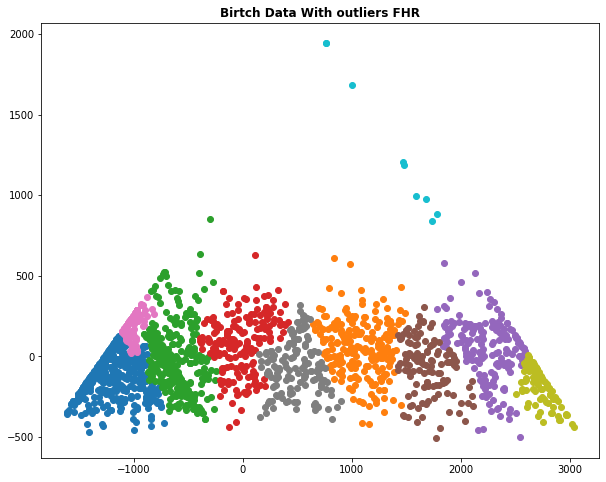

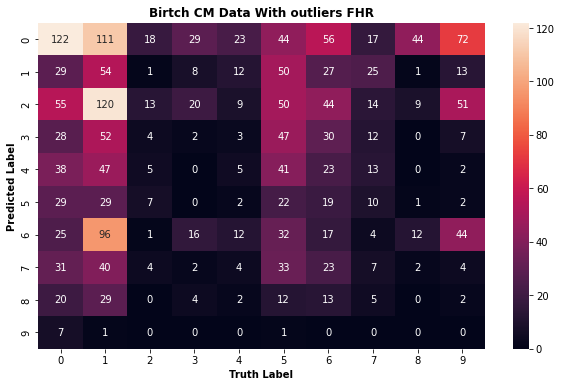

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Diagrams for: Standardized Data


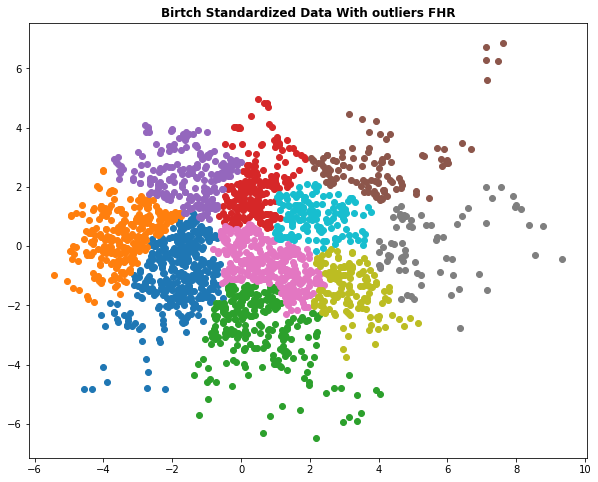

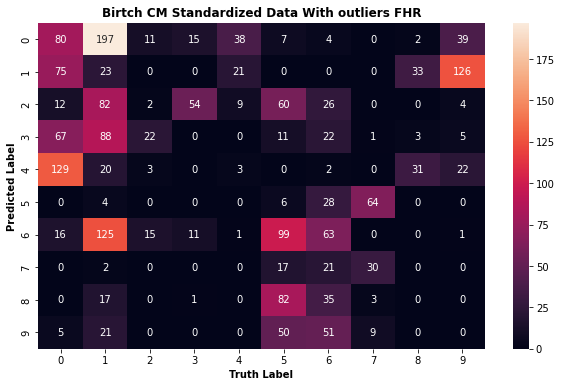

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                   Percentage of correct labeled:   Silhouette Score  \
Data                                      0.113829          0.386312   
Standardized Data                         0.097366          0.292775   

                   Fowlkes Mallows Score  Adjusted Mutual Info Score  
Data                            0.156195                    0.037111  
Standardized Data               0.264840                    0.292793  


In [16]:
birtch(y1,10)

---

Agglomerative

In [17]:
def agglomerative(y,n):
	p=[]#save percentage of correct labeled
	s=[]#save silhouette_score
	fm=[]#save fowlkes_mallows_score
	mi=[]#save adjusted_mutual_info_score
	
	if n==10:
		b='FHR'
	elif n==3:
		b='NSP'
	
	if len(y)==2110 or len(y)==2116:
		o=0
	elif len(y)==2126:
		o=1


	if o==0:
		dfs=[nx1, nx2]
		t="Without outliers"
		print(t)
	elif o==1:
		dfs=[x1, x2]
		t="With outliers"
		print(t)

	df_names=["Data", "Standardized Data"]

		
	for d in range(0,2):
		
		from sklearn.cluster import AgglomerativeClustering
		model3 = AgglomerativeClustering(n_clusters=n)
		# fit model and predict clusters
		yhat = model3.fit_predict(dfs[d])

		#failsafe 1
		if len(unique(y))!=len(unique(model3.labels_)):
			print("ny1:10 clusters, ny2:3 clusters")
			break

		print("Diagrams for:", df_names[d])
		# retrieve unique clusters
		clusters = unique(yhat)
		# create scatter plot for samples from each cluster
		plt.figure(figsize=(10,8))
		for cluster in clusters:
			# get row indexes for samples with this cluster
			row_ix = where(yhat == cluster)
			# create scatter of these samples
			plt.scatter(dfs[d][row_ix, 0], dfs[d][row_ix, 1])
			
		# show the plot
		plt.title("Agglomerative " + df_names[d]+" "+t+" "+b,fontweight='bold',c='black')
		plt.savefig('Agglomerative '+df_names[d]+" "+t+" "+b, dpi=300, bbox_inches='tight')
		plt.show()
		
		heatmap(y, model3.labels_, 3,d,t,b)

		pososta(c)
		p.append(pososta(c))

		from sklearn.metrics import silhouette_score
		s.append(silhouette_score(dfs[d], model3.labels_))

		from sklearn.metrics import fowlkes_mallows_score
		fm.append(fowlkes_mallows_score(y, model3.labels_))

		from sklearn.metrics import adjusted_mutual_info_score
		mi.append(adjusted_mutual_info_score(y, model3.labels_))

		print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
		
	#Failsafe 2
	if len(unique(y))!=len(unique(model3.labels_)):
		print("y1:10 clusters, y2:3 clusters")
		return

	a=pd.DataFrame(p)
	a.index=[df_names]
	a.columns=["Percentage of correct labeled: "]
	a['Silhouette Score']=s
	a['Fowlkes Mallows Score']=fm
	a['Adjusted Mutual Info Score']=mi
	a.to_excel('Agglomerative '+t+" "+b+'.xlsx',header=True)
	#print()
	print(a)

Without outliers
Diagrams for: Data


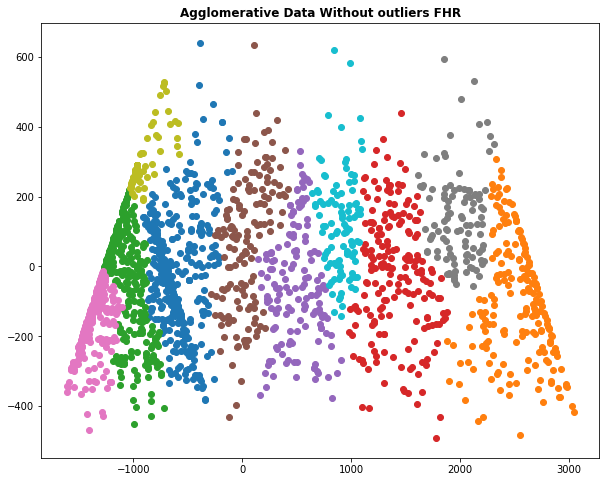

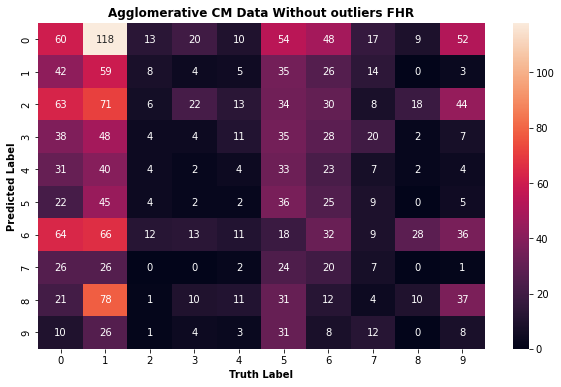

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Diagrams for: Standardized Data


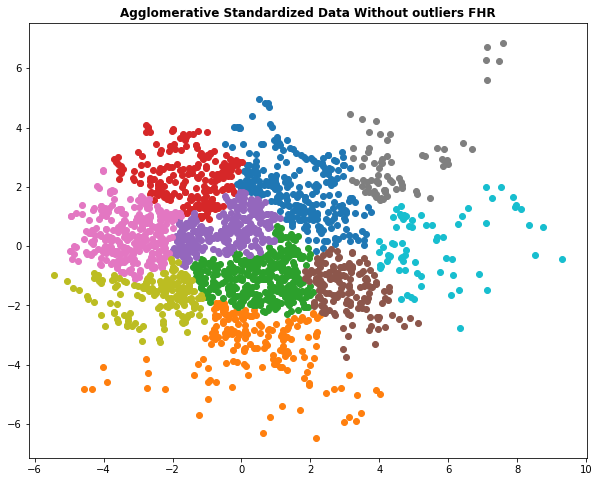

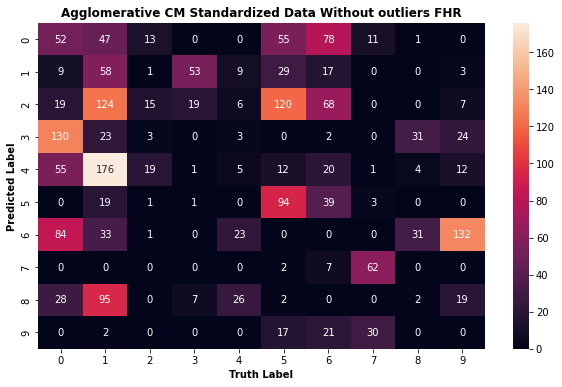

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                   Percentage of correct labeled:   Silhouette Score  \
Data                                      0.106805          0.368447   
Standardized Data                         0.136106          0.286758   

                   Fowlkes Mallows Score  Adjusted Mutual Info Score  
Data                            0.141967                    0.030693  
Standardized Data               0.263463                    0.288069  


In [18]:
agglomerative(ny1,10)

---